In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier


# Data Preprocessing

## Restore Variables from explore.ipynb

Use IPython's `%store -r` to restore the `df` dataframe and `continuous_vars` list that were stored at the end of `explore.ipynb`.

**Important**: Make sure you've run `explore.ipynb` first (at least up to the `%store` cells at the end) before running this notebook.

In [2]:
# Restore variables from explore.ipynb (suppress warnings)
import warnings
warnings.filterwarnings('ignore')

%store -r df
%store -r continuous_vars

# Verify they loaded
if 'df' not in locals():
    raise RuntimeError("df was not restored. Make sure you've run explore.ipynb and executed the %store cells at the end.")
if 'continuous_vars' not in locals():
    raise RuntimeError("continuous_vars was not restored. Make sure you've run explore.ipynb and executed the %store cells at the end.")

In [3]:
# Verify the variables were restored successfully
print(f"DataFrame shape: {df.shape}")
print(f"Continuous variables ({len(continuous_vars)}): {continuous_vars[:5]}...")  # show first 5
df.head(3)

DataFrame shape: (849999, 31)
Continuous variables (19): ['tenure_months', 'salary', 'performance_score', 'satisfaction_score', 'workload_score']...


,employee_id,role,job_level,department,tenure_months,salary,performance_score,satisfaction_score,workload_score,team_sentiment,...,goal_achievement_rate,stress_level,burnout_risk,left_company,turnover_reason,risk_factors_summary,turnover_probability_generated,persona_name,role_complexity_score,career_progression_score
0,SYN_00000000,Anonymous Employee,Mid,Research & Development,169,79704.579059,0.632482,0.623746,0.758117,0.662335,...,0.632482,0.908992,0.866643,False,Not Applicable,Severe Burnout Risk,0.290979,ChangeResistor,0.2,1.000000
1,SYN_00000001,Customer Success Manager,Manager,Research & Development,54,29694.288831,0.538587,0.982556,0.788416,0.934661,...,0.538587,0.363321,0.218996,False,Not Applicable,Low Risk,0.156002,NewEnthusiast,0.2,1.000000
2,SYN_00000002,Administrative Assistant,Entry,HR,1,62208.470185,0.624656,0.767200,0.697617,0.888559,...,0.624656,0.664378,0.541531,True,Personal / Relocation,Low Risk,0.233897,NewEnthusiast,0.2,0.836495


## Feature Engineering

In [4]:
# One-hot encoding categorical features
categorical_vars = ['role', 'job_level', 'department']
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
print('df_encoded shape:', df_encoded.shape)

# Normalize numerical variables
numeric_vars_to_scale = ['tenure_months', 'salary']
scaler = MinMaxScaler()

df_encoded[numeric_vars_to_scale] = scaler.fit_transform(df_encoded[numeric_vars_to_scale])


df_encoded shape: (849999, 364)


In [5]:
df_encoded.describe()

,tenure_months,salary,performance_score,satisfaction_score,workload_score,team_sentiment,project_completion_rate,overtime_hours,training_participation,collaboration_score,email_sentiment,slack_activity,meeting_participation,goal_achievement_rate,stress_level,burnout_risk,turnover_probability_generated,role_complexity_score,career_progression_score
count,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000,849999.000000
mean,0.194890,0.160644,0.692027,0.581941,0.599490,0.666848,0.595412,3.132903,0.279344,0.473380,0.582392,0.473380,0.473380,0.692027,0.791048,0.735941,0.285327,0.210859,0.841147
std,0.140947,0.132845,0.183911,0.276268,0.200038,0.178232,0.161173,6.094207,0.221602,0.184961,0.277255,0.184961,0.184961,0.183911,0.264536,0.315756,0.087902,0.085018,0.182216
min,0.000000,0.000000,0.074113,0.050000,0.006741,0.019774,0.059290,0.000000,0.000079,0.008674,0.042500,0.008674,0.008674,0.074113,0.000000,0.000000,0.131127,0.200000,0.182198
25%,0.081461,0.038686,0.571340,0.367016,0.455657,0.545729,0.490179,0.000000,0.103691,0.332366,0.367212,0.332366,0.332366,0.571340,0.613005,0.479950,0.227733,0.200000,0.713997
50%,0.185393,0.142767,0.699235,0.583188,0.613744,0.686320,0.609499,0.000000,0.223123,0.457102,0.583141,0.457102,0.457102,0.699235,0.942151,0.914494,0.299657,0.200000,0.911793
75%,0.292135,0.249079,0.825585,0.813912,0.756693,0.806540,0.716149,4.161240,0.400716,0.600885,0.811581,0.600885,0.600885,0.825585,1.000000,1.000000,0.335272,0.200000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.999615,0.999956,1.000000,73.953574,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.899983,1.000000,1.000000


In [6]:
from sklearn.decomposition import PCA


role_columns = [col for col in df_encoded.columns if col.startswith('role_')]
X_role = df_encoded[role_columns]

# 2. Run PCA
pca = PCA(n_components=2)  # use 2 for visualization
role_pca = pca.fit_transform(X_role)

# 3. Check explained variance
explained_var = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_var}")
print(f"Total variance explained by first 2 components: {explained_var.sum():.2f}")


Explained variance ratio: [0.3103183  0.02908918]
Total variance explained by first 2 components: 0.34


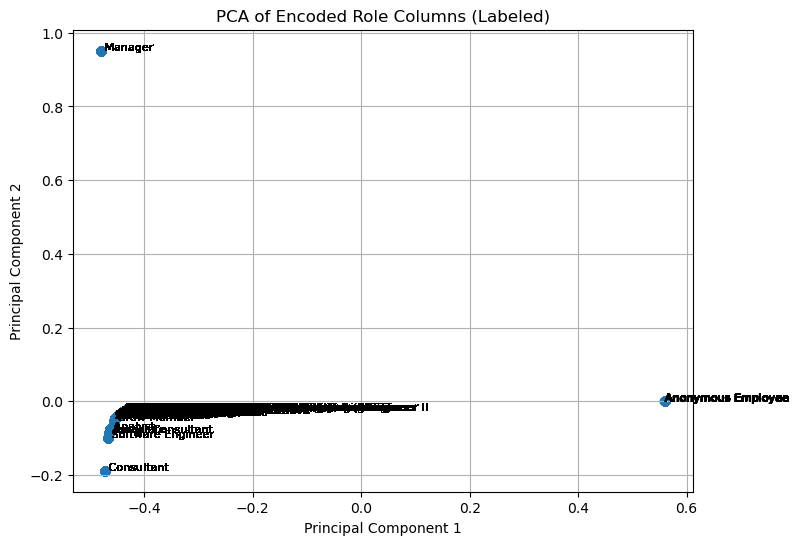

In [7]:
pca_df = pd.DataFrame(role_pca, columns=['PC1', 'PC2'])
pca_df['role_label'] = df['role'].values  # use the original (cleaned) role column

# 4. Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6)

# Add labels
for i, txt in enumerate(pca_df['role_label']):
    plt.annotate(
        txt,
        (pca_df['PC1'][i], pca_df['PC2'][i]),
        fontsize=8,
        alpha=0.7
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Encoded Role Columns (Labeled)')
plt.grid(True)
plt.show()

In [8]:
# View nulls
print(df_encoded.isnull().sum())

employee_id                        0
tenure_months                      0
salary                             0
performance_score                  0
satisfaction_score                 0
                                  ..
department_Software Engineering    0
department_Store Management        0
department_Technology              0
department_Training                0
department_nan                     0
Length: 364, dtype: int64


Since our dataset is synthetic, the data is generally clean and free of null values

In [9]:
# Drop 'object' columns
object_cols = df_encoded.select_dtypes(include='object').columns
print(object_cols)

Index(['employee_id', 'recent_feedback', 'communication_patterns',
       'technical_skills', 'soft_skills', 'turnover_reason',
       'risk_factors_summary', 'persona_name'],
      dtype='object')


In [10]:
# Separate target column and drop unneeded columns
X = df_encoded.drop(columns=list(object_cols) + ['left_company'])
y = df_encoded['left_company']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(679999, 355) (170000, 355)


In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_res, y_res = ros.fit_resample(X_train, y_train)

# Modeling (Random Forest)

In [12]:
# Model evaluation
def evaluate_model(y_true, y_pred, dataset):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_pred)
  print(dataset)
  print('Accuracy:', acc)
  print('Precision:', prec)
  print('Recall:', rec)
  print('F1-Score:', f1)
  print('ROC-AUC:', roc)

Train Set
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC-AUC: 1.0


Test Set
Accuracy: 0.7112176470588235
Precision: 0.46594068582020387
Recall: 0.08291928667147716
F1-Score: 0.14078443040411642
ROC-AUC: 0.5224876691804236


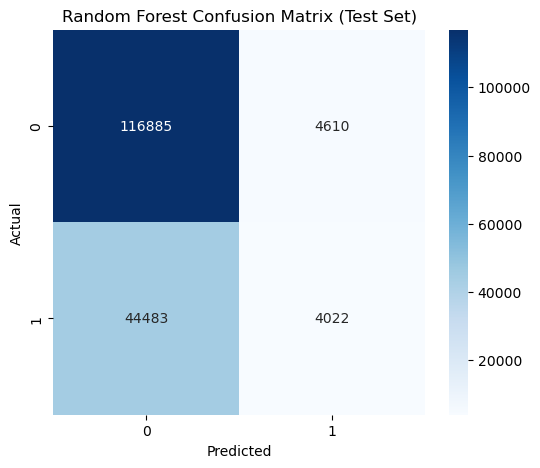

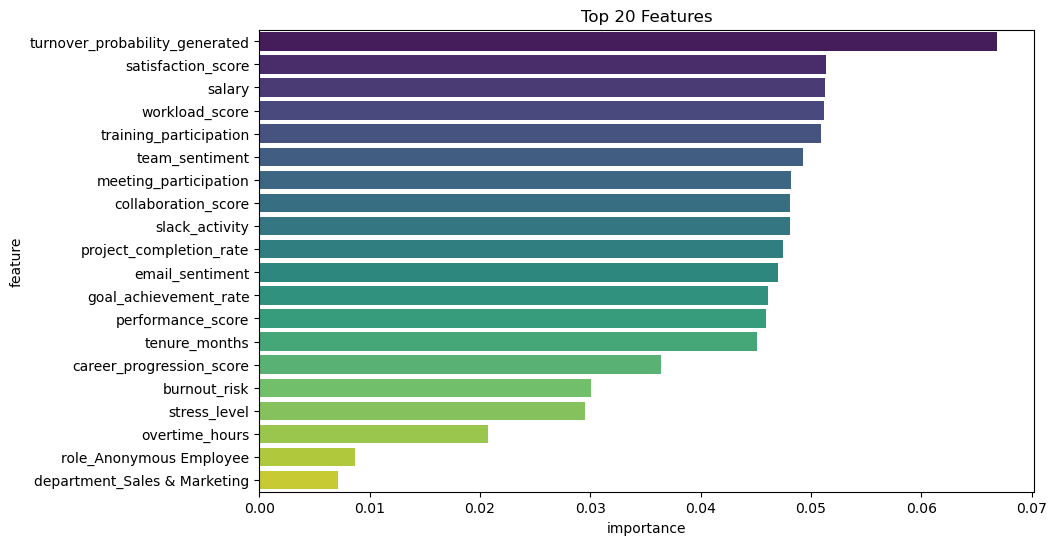

In [13]:
# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

# Fit model
rf_model.fit(X_res, y_res)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate
evaluate_model(y_train, y_train_pred, 'Train Set')
print('\n')
evaluate_model(y_test, y_test_pred, 'Test Set')

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importances
importances = rf_model.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')
plt.title('Top 20 Features')
plt.show()

In [14]:
# Feature importance table
importances = rf_model.feature_importances_
features = X_train.columns

feat_imp_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

feat_imp_df.head(20)


,feature,importance
16,turnover_probability_generated,0.066886
3,satisfaction_score,0.051350
1,salary,0.051225
4,workload_score,0.051153
8,training_participation,0.050868
5,team_sentiment,0.049258
12,meeting_participation,0.048150
9,collaboration_score,0.048058
11,slack_activity,0.048056
6,project_completion_rate,0.047472


# Modeling (Second Attempt - Undersample)

In [15]:
# Drop additional columns, addresing data leakage
X_train_2 = X_train.drop(columns = 'turnover_probability_generated')
X_test_2 = X_test.drop(columns = 'turnover_probability_generated')

print('Training shape:', X_train_2.shape)
print('Class ratio:', y_train.value_counts(normalize=True))

Training shape: (679999, 354)
Class ratio: left_company
False    0.714675
True     0.285325
Name: proportion, dtype: float64


In [16]:
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_2, y_train)

print('Before undersampling:', y_train.value_counts(normalize=True))
print('After undersampling:', y_train_res.value_counts(normalize=True))


Before undersampling: left_company
False    0.714675
True     0.285325
Name: proportion, dtype: float64
After undersampling: left_company
False    0.5
True     0.5
Name: proportion, dtype: float64


In [17]:
# Random Forest model (2nd attempt)
rf_model_improved = RandomForestClassifier(
    n_estimators=200,
    max_depth=10, # Added max_depth to reduce overfitting
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)

rf_model_improved.fit(X_train_res, y_train_res)

y_train_pred = rf_model_improved.predict(X_train_2)
y_test_pred = rf_model_improved.predict(X_test_2)

Train Set
Accuracy: 0.5323993123519299
Precision: 0.3322651452203544
Recall: 0.6327304776287103
F1-Score: 0.43572069977675004
ROC-AUC: 0.562536876213579
Test Set
Accuracy: 0.529464705882353
Precision: 0.32997451183687576
Recall: 0.6298938253788269
F1-Score: 0.4330779534646378
ROC-AUC: 0.5596318791489385


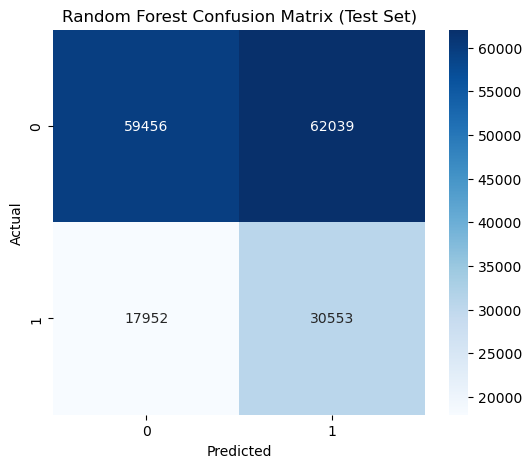


Top 20 Feature Importances:
                     feature  importance
                stress_level    0.169581
                burnout_risk    0.161950
             email_sentiment    0.148904
          satisfaction_score    0.127945
       meeting_participation    0.076433
         collaboration_score    0.053576
              slack_activity    0.052367
     project_completion_rate    0.041332
              workload_score    0.023581
           performance_score    0.017239
              team_sentiment    0.016161
              overtime_hours    0.016070
       goal_achievement_rate    0.015346
      training_participation    0.009730
    career_progression_score    0.008598
                      salary    0.007647
               tenure_months    0.006707
       role_complexity_score    0.000845
department_Sales & Marketing    0.000790
           role_ Team Member    0.000617


In [18]:
# Model evaluation
evaluate_model(y_train, y_train_pred, 'Train Set')
evaluate_model(y_test, y_test_pred, 'Test Set')

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
importances = rf_model_improved.feature_importances_
features = X_train_2.columns
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print("\nTop 20 Feature Importances:")
print(feat_imp_df.head(20).to_string(index=False))

# Modeling (Third Attempt - SMOTE + Subsample)

In [19]:
# Choose top features
top_features = [
    'stress_level', 'burnout_risk', 'email_sentiment', 'satisfaction_score',
    'meeting_participation', 'collaboration_score', 'slack_activity',
    'project_completion_rate', 'workload_score', 'performance_score',
    'team_sentiment', 'overtime_hours', 'goal_achievement_rate',
    'training_participation', 'career_progression_score', 'salary',
    'tenure_months', 'role_complexity_score', 'department_Sales & Marketing',
    'role_ Team Member'
]

# Subsample
X_train_sub = X_train_2[top_features].sample(n=50000, random_state=42)
y_train_sub = y_train.loc[X_train_sub.index]

X_test_sub = X_test_2[top_features].sample(n=20000, random_state=42)
y_test_sub = y_test.loc[X_test_sub.index]

print('Training subsample shape:', X_train_sub.shape)
print('Test subsample shape:', X_test_sub.shape)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sub, y_train_sub)

print('Class distribution after SMOTE:\n', y_train_res.value_counts(normalize=True))

# Model
brf_model = BalancedRandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

brf_model.fit(X_train_res, y_train_res)

# Predict
y_train_pred = brf_model.predict(X_train_res)
y_test_pred = brf_model.predict(X_test_sub)


Training subsample shape: (50000, 20)
Test subsample shape: (20000, 20)
Class distribution after SMOTE:
 left_company
True     0.5
False    0.5
Name: proportion, dtype: float64
Class distribution after SMOTE:
 left_company
True     0.5
False    0.5
Name: proportion, dtype: float64


In [20]:
# Evaluate
evaluate_model(y_train_res, y_train_pred, 'Train Set (Subsample + SMOTE)')
evaluate_model(y_test_sub, y_test_pred, '\nTest Set (Subsample)')

# Feature importance table
importances = brf_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': top_features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print('\nTop 20 Feature Importances:')
print(feat_imp_df.to_string(index=False))

Train Set (Subsample + SMOTE)
Accuracy: 0.6681849937124493
Precision: 0.6521552268992542
Recall: 0.7208606958222719
F1-Score: 0.6847889567294929
ROC-AUC: 0.6681849937124493

Test Set (Subsample)
Accuracy: 0.55555
Precision: 0.32320845989425134
Recall: 0.5
F1-Score: 0.392620430474889
ROC-AUC: 0.5389715167672232

Top 20 Feature Importances:
                     feature  importance
                      salary    0.109563
             email_sentiment    0.096114
          satisfaction_score    0.084188
                stress_level    0.083547
               tenure_months    0.078877
    career_progression_score    0.076675
                burnout_risk    0.073353
      training_participation    0.060154
              workload_score    0.050652
              team_sentiment    0.042320
     project_completion_rate    0.038033
         collaboration_score    0.038009
           performance_score    0.036549
       goal_achievement_rate    0.036126
       meeting_participation    0.035784
   

We want to prioritize high Recall as this measurement emphasizes the cost of False Negative (miss identifying an at-risk employee who then quits unexpected).
This is because this would lead to high  turnover rate and replacement costs, loss productivity, and team disruption.

We also want to prioritize Precision as this measurement emphasizes False Positive (flagging happy employees as an at-risk employee and waste resource on retention effort), albeit this usually costs less than False Negative in this case.

Thus, we also focus on F1-Score as this combines both of these metrics.

 Threshold  Precision   Recall       F1
       0.3   0.292365 0.965019 0.448770
       0.4   0.300493 0.817438 0.439444
       0.5   0.323208 0.500000 0.392620
       0.6   0.352090 0.114340 0.172622
       0.7   0.428571 0.000522 0.001043


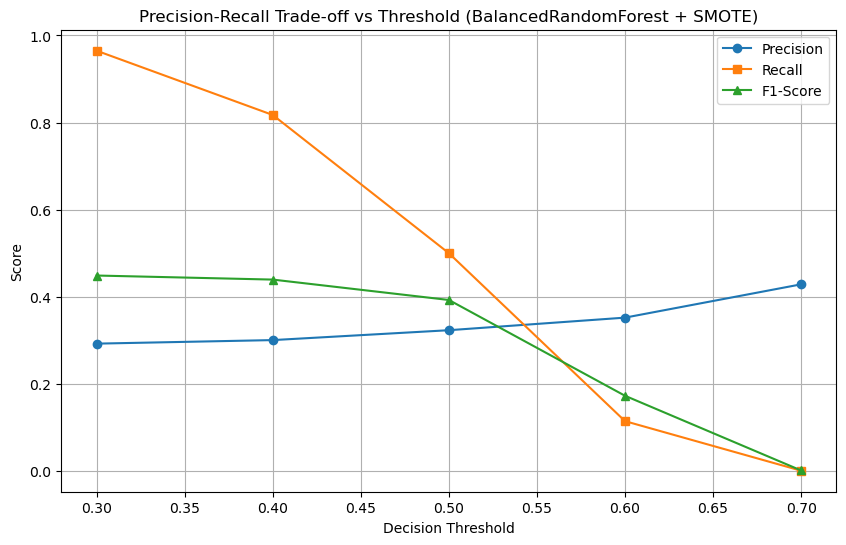

In [23]:
# Threshold tuning for recall vs precision trade-off
# Using the most sophisticated model (BalancedRandomForestClassifier with SMOTE)
y_test_proba = brf_model.predict_proba(X_test_sub)[:, 1]

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

for thresh in thresholds:
    y_pred_thresh = (y_test_proba >= thresh).astype(int)
    prec = precision_score(y_test_sub, y_pred_thresh)
    rec = recall_score(y_test_sub, y_pred_thresh)
    f1 = f1_score(y_test_sub, y_pred_thresh)
    results.append({'Threshold': thresh, 'Precision': prec, 'Recall': rec, 'F1': f1})

thresh_df = pd.DataFrame(results)
print(thresh_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresh_df['Threshold'], thresh_df['Precision'], marker='o', label='Precision')
ax.plot(thresh_df['Threshold'], thresh_df['Recall'], marker='s', label='Recall')
ax.plot(thresh_df['Threshold'], thresh_df['F1'], marker='^', label='F1-Score')
ax.set_xlabel('Decision Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision-Recall Trade-off vs Threshold (BalancedRandomForest + SMOTE)')
ax.legend()
ax.grid(True)
plt.show()

Based on this chart, we can use a threshold of 0.4 instead of the default 0.5 as we still have a relatively high recall and F1-Score and Precision has not gone too far down.

### Where Does the Model Fit in the Fitting Graph?

The **fitting graph** (bias-variance tradeoff) helps diagnose model performance:

```
High Train Error + High Test Error → Underfitting (High Bias)
Low Train Error + High Test Error  → Overfitting (High Variance)
Low Train Error + Low Test Error   → Good Fit (Optimal)
```

**Analysis:**

- We have **Train >> Test** (large gap): The model is **overfitting** - memorizing training data patterns that don't generalize
  - **Causes**: Model too complex, data leakage (e.g., `turnover_probability_generated`), insufficient regularization
  - **Solutions**: We removed leaky features, added regularization (max_depth, min_samples), will use cross-validation



## First Model Conclusions & Next Steps

### **Conclusion**: 

**Key Findings:**
1. **Severe Overfitting**: This initial model has severe overfitting, this could be caused by the imbalance in the target feature, `left_company`
2. **Data Leakage Identified**: The feature `turnover_probability_generated` is an example of data leakage because  `turnover_probability_generated` is essentially a derived/synthetic feature that's too predictive (described by dataset author as ML-predicted churn risk). The model is likely memorizing patterns rather than generalizing.
3. **Class Imbalance Impact**: The dataset has imbalanced classes (employees who stay are much more in numbers than employees who leave), this required specialized handling
4. **Feature Importance Insights**: Top predictors include behavioral/sentiment features (stress, burnout, satisfaction) and the leaky feature

**What This Model Does Well:**
- Successfully processes and encodes high-cardinality categorical features (300+ roles, 38 departments)
- Identifies meaningful behavioral predictors when leaky features are removed

### Potential Next Model

#### **1. Support Vector Machine (SVM) with RBF Kernel**
**Reasoning:**
- Can capture non-linear relationships through kernel trick
- Works well with normalized/scaled features
- Less prone to overfitting with proper regularization (C parameter)
- Good for high-dimensional data after removing one-hot encoded features

**Potential challenges:**
- Computationally expensive on large datasets (800K rows) - may need subsampling
- Requires careful hyperparameter tuning (C, gamma)
- Less interpretable than tree-based models
---
#### **2. XGBoost (Gradient Boosting)**
**Reasoning:**
- Good performance on tabular data
- Class imbalance handling via `scale_pos_weight`
- Regularization with (L1/L2, max_depth, min_child_weight) to prevent overfitting
- Feature importance via gain/cover metrics

**Advantages over Random Forest:**
- Sequential boosting learns from previous trees' mistakes (vs RF's independent trees)
- Better bias-variance tradeoff
- Typically higher accuracy on structured data
---
#### **3. Neural Network (Multi-Layer Perceptron)**
**Reasoning:**
- Can learn complex non-linear patterns
- Can incorporate text embeddings from `recent_feedback` (we will do sentiment analysis as this seems promising)
- Experimentation with Unsupervised learning

**Challenges:**
- Lecture on this has not happened yet
---